In [13]:
import torch
from transformers import AutoTokenizer, AutoModelForTokenClassification

In [14]:
# Tải mô hình và tokenizer
model_name = "peterhung/vietnamese-accent-marker-xlm-roberta"
tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space=True)
model = AutoModelForTokenClassification.from_pretrained(model_name)

In [15]:
# Upload file tags
from google.colab import files
print("Vui lòng upload file selected_tags_names.txt:")
uploaded = files.upload()

Vui lòng upload file selected_tags_names.txt:


Saving selected_tags_names.txt to selected_tags_names (1).txt


In [16]:
# Tải danh sách tags
def tai_danh_sach_tags(ten_file):
    """Tải danh sách tags từ file."""
    with open(ten_file, 'r', encoding='utf-8') as f:
        tags = [line.strip() for line in f.readlines()]
    return tags

# Tải tags
tags = tai_danh_sach_tags("selected_tags_names.txt")
print(f"Đã tải {len(tags)} tags")

Đã tải 528 tags


In [17]:
# Hàm áp dụng nhãn
def ap_dung_nhan(token, nhan):
    """Áp dụng nhãn để khôi phục dấu cho token."""
    if '-' not in nhan:
        return token

    raw, co_dau = nhan.split('-', 1)
    if raw in token:
        return token.replace(raw, co_dau, 1)
    else:
        return token

# Hàm làm sạch token
def lam_sach_token(token):
    """Làm sạch các ký hiệu đặc biệt từ token."""
    # Loại bỏ token đặc biệt
    if token in ['<s>', '</s>', '<pad>', '<unk>']:
        return ''
    # Loại bỏ ký hiệu subword ▁
    if token.startswith('▁'):
        return token[1:]
    return token

# Hàm chính khôi phục dấu
def khoi_phuc_dau_tieng_viet(van_ban):
    """Khôi phục dấu tiếng Việt cho văn bản đầu vào."""
    print(f"Văn bản gốc: {van_ban}")

    # Tokenize văn bản
    inputs = tokenizer(van_ban, return_tensors="pt", truncation=True)

    # Dự đoán nhãn
    with torch.no_grad():
        outputs = model(**inputs)
    predictions = torch.argmax(outputs.logits, dim=-1)

    # Chuyển đổi thành tokens
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

    # Áp dụng nhãn và làm sạch
    tokens_khoi_phuc = []
    for token, pred in zip(tokens, predictions[0].tolist()):
        # Làm sạch token
        token_sach = lam_sach_token(token)

        if token_sach:  # Chỉ xử lý token không rỗng
            nhan = tags[pred]
            token_co_dau = ap_dung_nhan(token_sach, nhan)
            tokens_khoi_phuc.append(token_co_dau)

    # Nối lại thành văn bản
    van_ban_co_dau = ' '.join(tokens_khoi_phuc)
    print(f"Văn bản có dấu: {van_ban_co_dau}")
    return van_ban_co_dau


In [20]:
# Ví dụ
van_ban = "toi la sinh vien khoa hoc du lieu"
ket_qua = khoi_phuc_dau_tieng_viet(van_ban)

Văn bản gốc: toi la sinh vien khoa hoc du lieu
Văn bản có dấu: tôi là sinh viên khoa học dữ liệu


In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import unicodedata
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')


In [23]:
# Thiết lập matplotlib cho tiếng Việt
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")

class VietnameseAccentEvaluator:
    def __init__(self, model, tokenizer, tags):
        """Khởi tạo với model, tokenizer và tags đã load sẵn."""
        self.model = model
        self.tokenizer = tokenizer
        self.tags = tags

    def remove_accents(self, text):
        """Loại bỏ dấu tiếng Việt."""
        # Mapping các ký tự có dấu sang không dấu
        accent_map = {
            'á': 'a', 'à': 'a', 'ả': 'a', 'ã': 'a', 'ạ': 'a',
            'ă': 'a', 'ắ': 'a', 'ằ': 'a', 'ẳ': 'a', 'ẵ': 'a', 'ặ': 'a',
            'â': 'a', 'ấ': 'a', 'ầ': 'a', 'ẩ': 'a', 'ẫ': 'a', 'ậ': 'a',
            'é': 'e', 'è': 'e', 'ẻ': 'e', 'ẽ': 'e', 'ẹ': 'e',
            'ê': 'e', 'ế': 'e', 'ề': 'e', 'ể': 'e', 'ễ': 'e', 'ệ': 'e',
            'í': 'i', 'ì': 'i', 'ỉ': 'i', 'ĩ': 'i', 'ị': 'i',
            'ó': 'o', 'ò': 'o', 'ỏ': 'o', 'õ': 'o', 'ọ': 'o',
            'ô': 'o', 'ố': 'o', 'ồ': 'o', 'ổ': 'o', 'ỗ': 'o', 'ộ': 'o',
            'ơ': 'o', 'ớ': 'o', 'ờ': 'o', 'ở': 'o', 'ỡ': 'o', 'ợ': 'o',
            'ú': 'u', 'ù': 'u', 'ủ': 'u', 'ũ': 'u', 'ụ': 'u',
            'ư': 'u', 'ứ': 'u', 'ừ': 'u', 'ử': 'u', 'ữ': 'u', 'ự': 'u',
            'ý': 'y', 'ỳ': 'y', 'ỷ': 'y', 'ỹ': 'y', 'ỵ': 'y',
            'đ': 'd'
        }

        result = ""
        for char in text.lower():
            result += accent_map.get(char, char)
        return result

    def predict_with_model(self, text):
        """Sử dụng hàm khoi_phuc_dau_tieng_viet đã có."""
        return khoi_phuc_dau_tieng_viet(text)

    def char_level_accuracy(self, predicted, ground_truth):
        """Tính độ chính xác ở mức ký tự."""
        # Loại bỏ khoảng trắng thừa
        pred_clean = ' '.join(predicted.split())
        truth_clean = ' '.join(ground_truth.split())

        if len(pred_clean) != len(truth_clean):
            # Tính accuracy với dynamic programming
            m, n = len(pred_clean), len(truth_clean)
            dp = [[0] * (n + 1) for _ in range(m + 1)]

            for i in range(m + 1):
                for j in range(n + 1):
                    if i == 0:
                        dp[i][j] = j
                    elif j == 0:
                        dp[i][j] = i
                    elif pred_clean[i-1] == truth_clean[j-1]:
                        dp[i][j] = dp[i-1][j-1]
                    else:
                        dp[i][j] = 1 + min(dp[i][j-1], dp[i-1][j], dp[i-1][j-1])

            # Accuracy dựa trên edit distance
            edit_distance = dp[m][n]
            max_len = max(m, n)
            return (max_len - edit_distance) / max_len if max_len > 0 else 1.0

        # Trường hợp cùng độ dài
        correct = sum(1 for p, g in zip(pred_clean, truth_clean) if p == g)
        return correct / len(truth_clean) if len(truth_clean) > 0 else 1.0

    def word_level_accuracy(self, predicted, ground_truth):
        """Tính độ chính xác ở mức từ."""
        pred_words = predicted.split()
        true_words = ground_truth.split()

        if len(pred_words) == 0 and len(true_words) == 0:
            return 1.0

        # Sử dụng dynamic programming để tìm LCS (Longest Common Subsequence)
        m, n = len(pred_words), len(true_words)
        dp = [[0] * (n + 1) for _ in range(m + 1)]

        for i in range(1, m + 1):
            for j in range(1, n + 1):
                if pred_words[i-1] == true_words[j-1]:
                    dp[i][j] = dp[i-1][j-1] + 1
                else:
                    dp[i][j] = max(dp[i-1][j], dp[i][j-1])

        lcs_length = dp[m][n]
        return lcs_length / max(m, n) if max(m, n) > 0 else 1.0

    def evaluate_samples(self, test_samples):
        """Đánh giá trên tập dữ liệu mẫu."""
        results = {
            'char_accuracy': [],
            'word_accuracy': [],
            'input_text': [],
            'predicted_text': [],
            'ground_truth': [],
            'processing_successful': []
        }

        print(f"Đánh giá trên {len(test_samples)} mẫu...")

        for i, ground_truth in enumerate(test_samples):
            try:
                # Tạo input bằng cách loại bỏ dấu
                input_text = self.remove_accents(ground_truth)

                # Dự đoán (sử dụng hàm đã có, tắt print)
                import sys
                from io import StringIO

                # Capture stdout to suppress prints
                old_stdout = sys.stdout
                sys.stdout = StringIO()

                predicted = khoi_phuc_dau_tieng_viet(input_text)

                # Restore stdout
                sys.stdout = old_stdout

                # Tính các độ đo
                char_acc = self.char_level_accuracy(predicted, ground_truth)
                word_acc = self.word_level_accuracy(predicted, ground_truth)

                results['char_accuracy'].append(char_acc)
                results['word_accuracy'].append(word_acc)
                results['input_text'].append(input_text)
                results['predicted_text'].append(predicted)
                results['ground_truth'].append(ground_truth)
                results['processing_successful'].append(True)

                if (i + 1) % 5 == 0:
                    print(f"Đã xử lý {i + 1}/{len(test_samples)} mẫu")

            except Exception as e:
                print(f"Lỗi khi xử lý mẫu {i}: {str(e)}")
                results['processing_successful'].append(False)

        print(f"Hoàn thành đánh giá!")
        return results


In [24]:
# Tạo dữ liệu test mở rộng
test_samples_extended = [
    # Các câu đơn giản
    "Tôi là sinh viên khoa học dữ liệu",
    "Hôm nay trời đẹp, chúng ta đi chơi nhé",
    "Việt Nam là một đất nước xinh đẹp",
    "Học máy và trí tuệ nhân tạo rất thú vị",
    "Chúng tôi đang phát triển ứng dụng mới",

    # Các câu phức tạp hơn
    "Ngôn ngữ tiếng Việt có nhiều dấu thanh",
    "Công nghệ thông tin phát triển nhanh chóng",
    "Sinh viên cần học tập chăm chỉ để thành công",
    "Dự án này rất quan trọng đối với chúng tôi",
    "Mô hình deep learning cho kết quả tốt",

    # Các câu có từ khó
    "Nghiên cứu khoa học đòi hỏi sự kiên trì",
    "Ứng dụng trí tuệ nhân tạo trong y tế",
    "Xử lý ngôn ngữ tự nhiên là lĩnh vực thú vị",
    "Thuật toán học máy ngày càng tinh vi",
    "Phân tích dữ liệu lớn cần công cụ mạnh",

    # Câu ngắn và dài
    "Xin chào",
    "Cảm ơn bạn",
    "Chào tạm biệt",
    "Hôm nay tôi học được nhiều kiến thức mới về xử lý ngôn ngữ tự nhiên và ứng dụng của nó trong cuộc sống",
    "Việc phát triển các mô hình AI để hỗ trợ xử lý tiếng Việt là một công việc đầy thử thách nhưng rất ý nghĩa"
]

In [25]:
# Khởi tạo evaluator với model đã load
evaluator = VietnameseAccentEvaluator(model, tokenizer, tags)

# Chạy đánh giá
results = evaluator.evaluate_samples(test_samples_extended)

# In kết quả tổng quan
print(f"\n{'='*50}")
print(f"KẾT QUẢ ĐÁNH GIÁ MÔ HÌNH")
print(f"{'='*50}")
print(f"Tổng số mẫu: {len(results['char_accuracy'])}")
print(f"Độ chính xác ký tự trung bình: {np.mean(results['char_accuracy']):.4f} ± {np.std(results['char_accuracy']):.4f}")
print(f"Độ chính xác từ trung bình: {np.mean(results['word_accuracy']):.4f} ± {np.std(results['word_accuracy']):.4f}")
print(f"Độ chính xác ký tự tối thiểu: {np.min(results['char_accuracy']):.4f}")
print(f"Độ chính xác ký tự tối đa: {np.max(results['char_accuracy']):.4f}")
print(f"Độ chính xác từ tối thiểu: {np.min(results['word_accuracy']):.4f}")
print(f"Độ chính xác từ tối đa: {np.max(results['word_accuracy']):.4f}")


Đánh giá trên 20 mẫu...
Đã xử lý 5/20 mẫu
Đã xử lý 10/20 mẫu
Đã xử lý 15/20 mẫu
Đã xử lý 20/20 mẫu
Hoàn thành đánh giá!

KẾT QUỢ ĐÁNH GIÁ MÔ HÌNH
Tổng số mẫu: 20
Độ chính xác ký tự trung bình: 0.8619 ± 0.0822
Độ chính xác từ trung bình: 0.4647 ± 0.2142
Độ chính xác ký tự tối thiểu: 0.6667
Độ chính xác ký tự tối đa: 0.9697
Độ chính xác từ tối thiểu: 0.0000
Độ chính xác từ tối đa: 0.8750


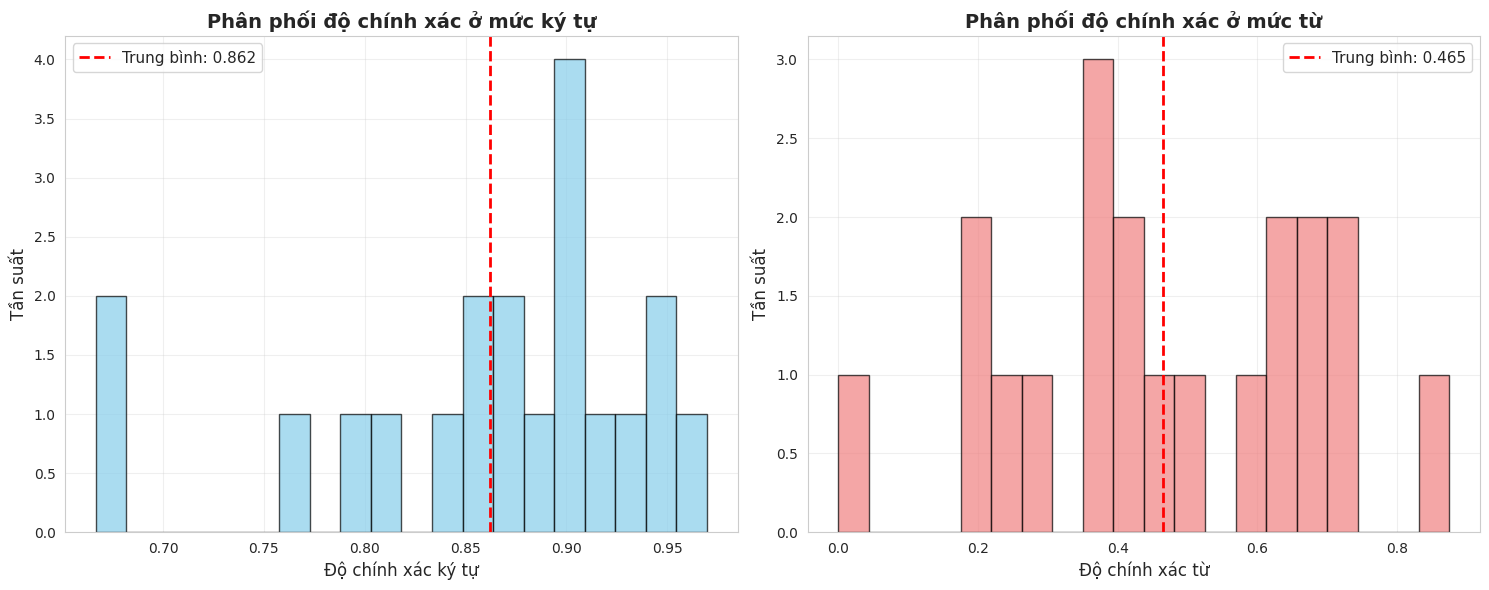

In [26]:
# 1. Biểu đồ phân phối độ chính xác
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Histogram cho độ chính xác ký tự
ax1.hist(results['char_accuracy'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
ax1.axvline(np.mean(results['char_accuracy']), color='red', linestyle='--', linewidth=2,
           label=f'Trung bình: {np.mean(results["char_accuracy"]):.3f}')
ax1.set_xlabel('Độ chính xác ký tự', fontsize=12)
ax1.set_ylabel('Tần suất', fontsize=12)
ax1.set_title('Phân phối độ chính xác ở mức ký tự', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Histogram cho độ chính xác từ
ax2.hist(results['word_accuracy'], bins=20, alpha=0.7, color='lightcoral', edgecolor='black')
ax2.axvline(np.mean(results['word_accuracy']), color='red', linestyle='--', linewidth=2,
           label=f'Trung bình: {np.mean(results["word_accuracy"]):.3f}')
ax2.set_xlabel('Độ chính xác từ', fontsize=12)
ax2.set_ylabel('Tần suất', fontsize=12)
ax2.set_title('Phân phối độ chính xác ở mức từ', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

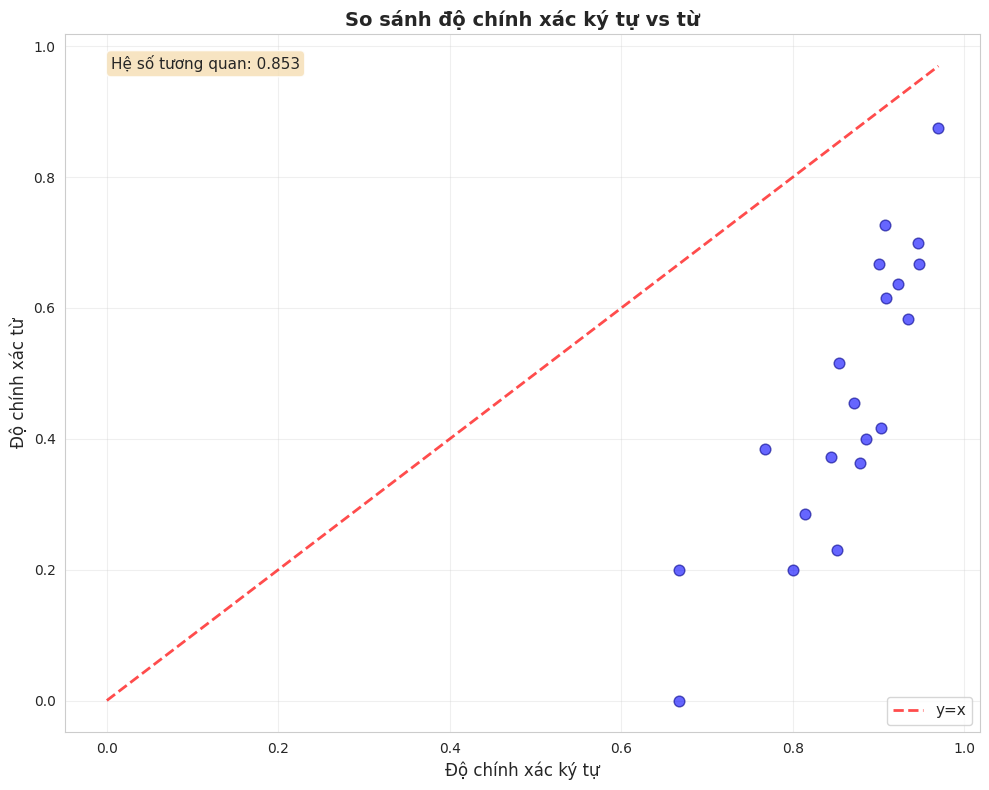

In [27]:
# 2. Biểu đồ so sánh scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(results['char_accuracy'], results['word_accuracy'],
           alpha=0.6, s=60, color='blue', edgecolor='darkblue')

# Đường y=x để tham chiếu
min_val = min(min(results['char_accuracy']), min(results['word_accuracy']))
max_val = max(max(results['char_accuracy']), max(results['word_accuracy']))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.7, linewidth=2, label='y=x')

plt.xlabel('Độ chính xác ký tự', fontsize=12)
plt.ylabel('Độ chính xác từ', fontsize=12)
plt.title('So sánh độ chính xác ký tự vs từ', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Thêm correlation coefficient
corr = np.corrcoef(results['char_accuracy'], results['word_accuracy'])[0, 1]
plt.text(0.05, 0.95, f'Hệ số tương quan: {corr:.3f}', transform=plt.gca().transAxes,
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8), fontsize=11)

plt.tight_layout()
plt.show()

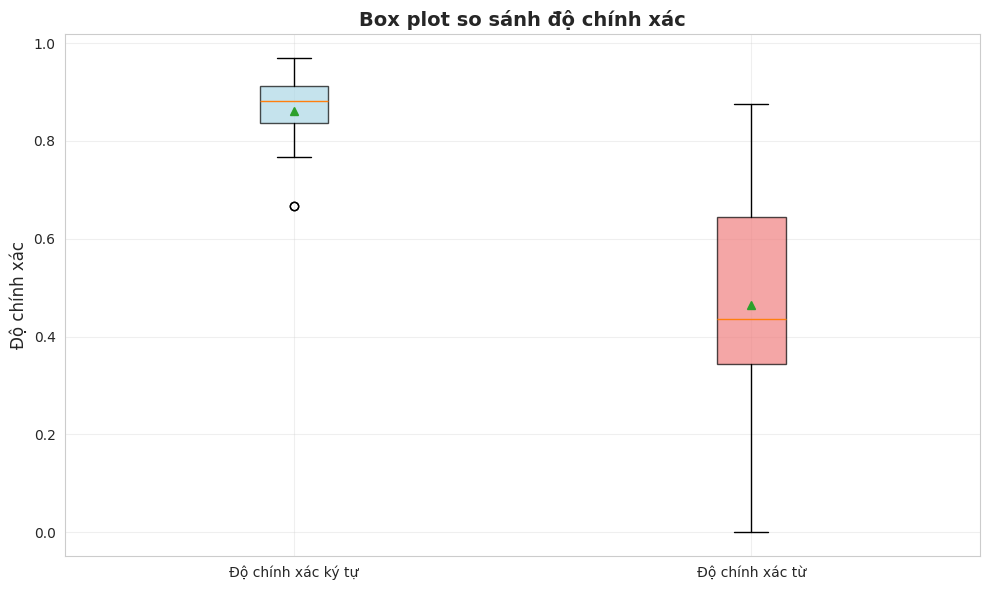

In [28]:
# 3. Box plot so sánh
plt.figure(figsize=(10, 6))
data_to_plot = [results['char_accuracy'], results['word_accuracy']]
box = plt.boxplot(data_to_plot, labels=['Độ chính xác ký tự', 'Độ chính xác từ'],
                  patch_artist=True, showmeans=True)

# Tô màu cho box plot
colors = ['lightblue', 'lightcoral']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

plt.ylabel('Độ chính xác', fontsize=12)
plt.title('Box plot so sánh độ chính xác', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


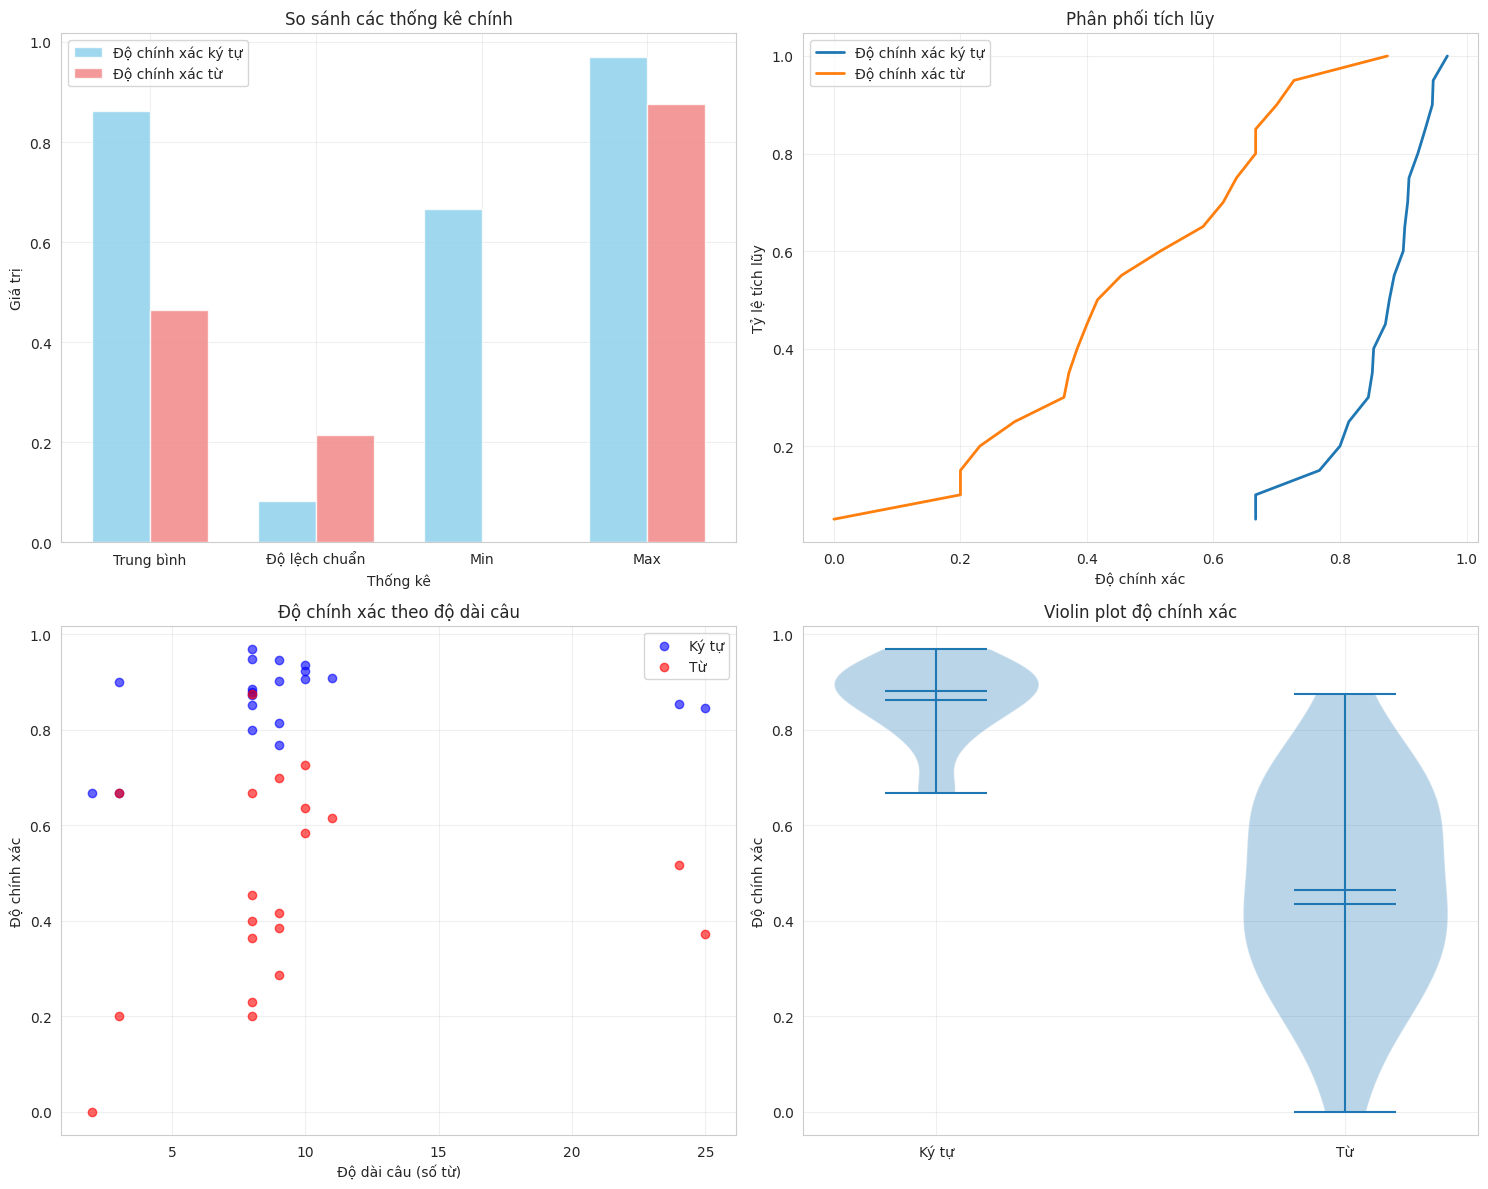

In [29]:
# 4. Biểu đồ thống kê chi tiết
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Thống kê tổng hợp
metrics = ['Trung bình', 'Độ lệch chuẩn', 'Min', 'Max']
char_stats = [np.mean(results['char_accuracy']), np.std(results['char_accuracy']),
              np.min(results['char_accuracy']), np.max(results['char_accuracy'])]
word_stats = [np.mean(results['word_accuracy']), np.std(results['word_accuracy']),
              np.min(results['word_accuracy']), np.max(results['word_accuracy'])]

x = np.arange(len(metrics))
width = 0.35
ax1.bar(x - width/2, char_stats, width, label='Độ chính xác ký tự', alpha=0.8, color='skyblue')
ax1.bar(x + width/2, word_stats, width, label='Độ chính xác từ', alpha=0.8, color='lightcoral')
ax1.set_xlabel('Thống kê')
ax1.set_ylabel('Giá trị')
ax1.set_title('So sánh các thống kê chính')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Cumulative distribution
sorted_char = np.sort(results['char_accuracy'])
sorted_word = np.sort(results['word_accuracy'])
y_char = np.arange(1, len(sorted_char) + 1) / len(sorted_char)
y_word = np.arange(1, len(sorted_word) + 1) / len(sorted_word)

ax2.plot(sorted_char, y_char, label='Độ chính xác ký tự', linewidth=2)
ax2.plot(sorted_word, y_word, label='Độ chính xác từ', linewidth=2)
ax2.set_xlabel('Độ chính xác')
ax2.set_ylabel('Tỷ lệ tích lũy')
ax2.set_title('Phân phối tích lũy')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Phân tích theo độ dài câu
sentence_lengths = [len(text.split()) for text in results['ground_truth']]
ax3.scatter(sentence_lengths, results['char_accuracy'], alpha=0.6, color='blue', label='Ký tự')
ax3.scatter(sentence_lengths, results['word_accuracy'], alpha=0.6, color='red', label='Từ')
ax3.set_xlabel('Độ dài câu (số từ)')
ax3.set_ylabel('Độ chính xác')
ax3.set_title('Độ chính xác theo độ dài câu')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Biểu đồ violin plot
data_combined = [results['char_accuracy'], results['word_accuracy']]
parts = ax4.violinplot(data_combined, positions=[1, 2], showmeans=True, showmedians=True)
ax4.set_xticks([1, 2])
ax4.set_xticklabels(['Ký tự', 'Từ'])
ax4.set_ylabel('Độ chính xác')
ax4.set_title('Violin plot độ chính xác')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [30]:
# 5. In một số ví dụ chi tiết
print(f"\n{'='*80}")
print(f"CÁC VÍ DỤ DỰ ĐOÁN CHI TIẾT")
print(f"{'='*80}")

# Sắp xếp theo accuracy để hiển thị các trường hợp tốt nhất và tệ nhất
indices_sorted = sorted(range(len(results['char_accuracy'])),
                       key=lambda i: results['char_accuracy'][i])

print(f"\n🟢 CÁC TRƯỜNG HỢP TỐT NHẤT:")
for i in indices_sorted[-3:]:
    print(f"\nVí dụ {i+1}:")
    print(f"Input:     {results['input_text'][i]}")
    print(f"Predicted: {results['predicted_text'][i]}")
    print(f"Truth:     {results['ground_truth'][i]}")
    print(f"Char acc:  {results['char_accuracy'][i]:.4f}")
    print(f"Word acc:  {results['word_accuracy'][i]:.4f}")

print(f"\n🔴 CÁC TRƯỜNG HỢP CẦN CẢI THIỆN:")
for i in indices_sorted[:3]:
    print(f"\nVí dụ {i+1}:")
    print(f"Input:     {results['input_text'][i]}")
    print(f"Predicted: {results['predicted_text'][i]}")
    print(f"Truth:     {results['ground_truth'][i]}")
    print(f"Char acc:  {results['char_accuracy'][i]:.4f}")
    print(f"Word acc:  {results['word_accuracy'][i]:.4f}")


CÁC VÍ DỤ DỰ ĐOÁN CHI TIẾT

🟢 CÁC TRƯỜNG HỢP TỐT NHẤT:

Ví dụ 12:
Input:     ung dung tri tue nhan tao trong y te
Predicted: ứng dụng trí tuệ n hân tạo trong y tế
Truth:     Ứng dụng trí tuệ nhân tạo trong y tế
Char acc:  0.9459
Word acc:  0.7000

Ví dụ 10:
Input:     mo hinh deep learning cho ket qua tot
Predicted: mô hìn h deep learning cho kết quả tốt
Truth:     Mô hình deep learning cho kết quả tốt
Char acc:  0.9474
Word acc:  0.6667

Ví dụ 1:
Input:     toi la sinh vien khoa hoc du lieu
Predicted: tôi là sinh viên khoa học dữ liệu
Truth:     Tôi là sinh viên khoa học dữ liệu
Char acc:  0.9697
Word acc:  0.8750

🔴 CÁC TRƯỜNG HỢP CẦN CẢI THIỆN:

Ví dụ 16:
Input:     xin chao
Predicted: xin cha o
Truth:     Xin chào
Char acc:  0.6667
Word acc:  0.0000

Ví dụ 18:
Input:     chao tam biet
Predicted: cha o tạm bi et
Truth:     Chào tạm biệt
Char acc:  0.6667
Word acc:  0.2000

Ví dụ 11:
Input:     nghien cuu khoa hoc doi hoi su kien tri
Predicted: nghi en cu u khoa học do i hỏi sự ki e